# Variational Auto-Encoder (VAE)

### Zhenwen Dai (2019-05-29)

Variational auto-encoder (VAE) is a latent variable model that uses a latent variable to generate data represented in vector form. Consider a latent variable $x$ and an observed variable $y$. The plain VAE is defined as
\begin{align}
p(x) =& \mathcal{N}(0, I) \\
p(y|x) =& \mathcal{N}(f(x), \sigma^2I)
\end{align}
where $f$ is the deep neural network (DNN), often referred to as the decoder network.

The variational posterior of VAE is defined as 
\begin{align}
q(x) = \mathcal{N}\left(g_{\mu}(y), \sigma^2_x I)\right)
\end{align}
where $g_{\mu}$ is the encoder networks that generate the mean of the variational posterior of $x$. For simplicity, we assume that all the data points share the same variance in the variational posteior. This can be extended by generating the variance also from the encoder network.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference
%matplotlib inline
from pylab import *

## Load a toy dataset

In [2]:
import GPy
data = GPy.util.datasets.oil_100()
Y = data['X']
label = data['Y'].argmax(1)

In [3]:
N, D = Y.shape

## Model Defintion

We first define that the encoder and decoder DNN with MXNet Gluon blocks. Both DNNs have two hidden layers with tanh non-linearity.

In [4]:
Q = 2

In [5]:
H = 50
encoder = nn.HybridSequential(prefix='encoder_')
with encoder.name_scope():
    encoder.add(nn.Dense(H, in_units=D, activation="tanh", flatten=False))
    encoder.add(nn.Dense(H, in_units=H, activation="tanh", flatten=False))
    encoder.add(nn.Dense(Q, in_units=H, flatten=False))
encoder.initialize(mx.init.Xavier(magnitude=3))

In [6]:
H = 50
decoder = nn.HybridSequential(prefix='decoder_')
with decoder.name_scope():
    decoder.add(nn.Dense(H, in_units=Q, activation="tanh", flatten=False))
    decoder.add(nn.Dense(H, in_units=H, activation="tanh", flatten=False))
    decoder.add(nn.Dense(D, in_units=H, flatten=False))
decoder.initialize(mx.init.Xavier(magnitude=3))

Then, we define the model of VAE in MXFusion. Note that for simplicity in implementation, we use scalar normal distributions defined for individual entries of a Matrix instead of multivariate normal distributions with diagonal covariance matrices.

In [8]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion import Variable, Model, Posterior
from mxfusion.components.functions import MXFusionGluonFunction
from mxfusion.components.distributions import Normal
from mxfusion.components.functions.operators import broadcast_to

m = Model()
m.N = Variable()
m.decoder = MXFusionGluonFunction(decoder, num_outputs=1,broadcastable=True)
m.x = Normal.define_variable(mean=broadcast_to(mx.nd.array([0]), (m.N, Q)),
                             variance=broadcast_to(mx.nd.array([1]), (m.N, Q)), shape=(m.N, Q))
m.f = m.decoder(m.x)
m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.y = Normal.define_variable(mean=m.f, variance=broadcast_to(m.noise_var, (m.N, D)), 
                             shape=(m.N, D))
print(m)

Model (37a04)
Variable (b92c2) = BroadcastToOperator(data=Variable noise_var (a50d4))
Variable (39c2c) = BroadcastToOperator(data=Variable (e1aad))
Variable (b7150) = BroadcastToOperator(data=Variable (a57d4))
Variable x (53056) ~ Normal(mean=Variable (b7150), variance=Variable (39c2c))
Variable f (ad606) = GluonFunctionEvaluation(decoder_input_0=Variable x (53056), decoder_dense0_weight=Variable (b9b70), decoder_dense0_bias=Variable (d95aa), decoder_dense1_weight=Variable (73dc2), decoder_dense1_bias=Variable (b85dd), decoder_dense2_weight=Variable (7a61c), decoder_dense2_bias=Variable (eba91))
Variable y (23bca) ~ Normal(mean=Variable f (ad606), variance=Variable (b92c2))


We also define the variational posterior following the equation above.

In [9]:
q = Posterior(m)
q.x_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([1e-6]))
q.encoder = MXFusionGluonFunction(encoder, num_outputs=1, broadcastable=True)
q.x_mean = q.encoder(q.y)
q.x.set_prior(Normal(mean=q.x_mean, variance=broadcast_to(q.x_var, q.x.shape)))
print(q)

Posterior (4ec05)
Variable x_mean (86d22) = GluonFunctionEvaluation(encoder_input_0=Variable y (23bca), encoder_dense0_weight=Variable (51b3d), encoder_dense0_bias=Variable (c0092), encoder_dense1_weight=Variable (ad9ef), encoder_dense1_bias=Variable (83db0), encoder_dense2_weight=Variable (78b82), encoder_dense2_bias=Variable (b856d))
Variable (6dc84) = BroadcastToOperator(data=Variable x_var (19d07))
Variable x (53056) ~ Normal(mean=Variable x_mean (86d22), variance=Variable (6dc84))


## Variational Inference

Variational inference is done via creating an inference object and passing in the stochastic variational inference algorithm.

In [11]:
from mxfusion.inference import BatchInferenceLoop, StochasticVariationalInference, GradBasedInference

observed = [m.y]
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

SVI is a gradient-based algorithm. We can run the algorithm by providing the data and specifying the parameters for the gradient optimizer (the default gradient optimizer is Adam).

In [13]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(Y), verbose=True)

Iteration 200 loss: 1720.556396484375					
Iteration 400 loss: 601.11962890625							
Iteration 600 loss: 168.620849609375						
Iteration 800 loss: -48.67474365234375					
Iteration 1000 loss: -207.34835815429688				
Iteration 1200 loss: -354.17742919921875				
Iteration 1400 loss: -356.26409912109375				
Iteration 1600 loss: -561.263427734375						
Iteration 1800 loss: -697.8665161132812					
Iteration 2000 loss: -753.83203125				8					


## Plot the training data in the latent space

Finally, we may be interested in visualizing the latent space of our dataset. We can do that by calling encoder network.

In [17]:
from mxfusion.inference import TransferInference

q_x_mean = q.encoder.gluon_block(mx.nd.array(Y)).asnumpy()

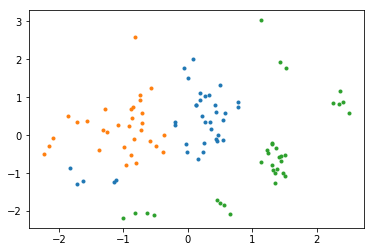

In [18]:
for i in range(3):
    plot(q_x_mean[label==i,0], q_x_mean[label==i,1], '.')